# Lecture 7: Class demo

In [1]:
import os
import sys

sys.path.append("../code/.")

import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from utils import *

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

## Demo: Model interpretation of linear classifiers

- One of the primary advantages of linear classifiers is their ability to interpret models.
- For instance, by analyzing the sign and magnitude of the learned coefficients, we can address questions regarding which features are influencing the prediction and in which direction.

- We'll demonstrate this by training `LogisticRegression` on the famous [IMDB movie review](https://www.kaggle.com/datasets/uttam94/imdb-mastercsv) dataset. The dataset is a bit large for demonstration purposes. So I am going to put a big portion of it in the test split to speed things up. 

In [2]:
imdb_df = pd.read_csv("../data/imdb_master.csv", encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df["sentiment"].str.startswith(("pos", "neg"))]
# imdb_df.drop(["Unnamed: 0", "type", "file"], axis=1, inplace=True)
imdb_df.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",positive


Let's clean up the data a bit. 

In [3]:
import re

def replace_tags(doc):
    doc = doc.replace("<br />", " ")
    doc = re.sub("https://\\S*", "", doc)
    return doc

In [4]:
imdb_df["review_pp"] = imdb_df["review"].apply(replace_tags)

Are we breaking the Golden rule here? 

Let's split the data and create bag of words representation. 

In [5]:
train_df, test_df = train_test_split(imdb_df, test_size=0.9, random_state=123)
X_train, y_train = train_df["review_pp"], train_df["sentiment"]
X_test, y_test = test_df["review_pp"], test_df["sentiment"]
train_df.shape

(5000, 3)

In [6]:
X_train

47278    First of all,there is a detective story:"lÃ©gitime dÃ©fense" by Belgian Stanislas AndrÃ© Steeman whose "l'assassin habite au 21" Clouzot had already transferred to the screen in 1942,with Pierre F...
19664    this attempt at a "thriller" would have no substance at all! Some may state that this movie "has it all?" Autism, arson, robbery, lost love, a bag of money, cut throats, murder, blood, a snub nose...
22648    What's the matter with you people? John Dahl? From "Rounders" and "Unforgettable"? TOO Quirky? Knocking emma Thompson and Alan Rickman for having fun playing against type? And somebody liked the G...
33662    This is another one of those films that I remember staying up late to watch on TV, scaring the crap out of myself at the impressionable age of 12 or so and dooming myself thereafter to a life of h...
31230    I love Ben Kingsley and Tea Leoni. However, this is easily the worst movie I have seen in 10 years, and I see my share of movies. A stinker. This is a bad 

Is there any missing data?

In [7]:
train_df.isna().sum()

review       0
sentiment    0
review_pp    0
dtype: int64

There is no missing data. We don't need imputation. 

In [8]:
# Let's try CountVectorizer
vec = CountVectorizer(max_features=10_000, stop_words="english")
bow = vec.fit_transform(X_train)
bow

<5000x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 387967 stored elements in Compressed Sparse Row format>

### Examining the vocabulary

- The vocabulary (mapping from feature indices to actual words) can be obtained using `get_feature_names()` on the `CountVectorizer` object. 

In [9]:
vocab = vec.get_feature_names_out()

In [10]:
vocab[0:10]  # first few words



array(['00', '000', '007', '10', '100', '1000', '101', '11', '12', '13'],
      dtype=object)

In [11]:
vocab[2000:2010]  # some middle words

array(['constantly', 'constructed', 'construction', 'consumed',
       'consumption', 'contact', 'contacts', 'contain', 'contained',
       'containing'], dtype=object)

In [12]:
vocab[::500]  # words with a step of 500

array(['00', 'annoyance', 'billion', 'cbs', 'constantly', 'destroyed',
       'emotions', 'fired', 'greek', 'iconic', 'kathleen', 'madsen',
       'myers', 'path', 'psychic', 'ripped', 'sheriff', 'statues',
       'testing', 'vanity'], dtype=object)

### Model building on the dataset 

First let's try `DummyClassifier` on the dataset. 

In [13]:
dummy = DummyClassifier()
cross_val_score(dummy, X_train, y_train).mean()

0.5034000000000001

We have a balanced dataset. So the `DummyClassifier` score is around 0.5. 

Now let's try logistic regression. 

In [14]:
# Create a pipeline with CountVectorizer and LogisticRegression 
pipe_lr = make_pipeline(CountVectorizer(max_features=10_000, stop_words="english"),
                        LogisticRegression(max_iter=1000)
                       )
scores = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,1.779838,0.295741,0.832,0.99975
1,1.606754,0.283948,0.825,0.99975
2,1.671219,0.304494,0.841,0.99975
3,1.671772,0.286870,0.828,1.00000
4,1.804580,0.286442,0.844,0.99975


Seems like we are overfitting. Let's optimize the hyperparameter `C`. 

In [15]:
scores_dict = {
    "C": 10.0 ** np.arange(-3, 3, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for C in scores_dict["C"]:
    pipe_lr = make_pipeline(CountVectorizer(max_features=10_000, stop_words="english"),
                        LogisticRegression(max_iter=1000, C=C)
                       )
    scores = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df

,C,mean_train_scores,mean_cv_scores
0,0.001,0.82615,0.7864
1,0.010,0.91795,0.8322
2,0.100,0.98570,0.8422
3,1.000,0.99980,0.8340
4,10.000,1.00000,0.8256
5,100.000,1.00000,0.8312


In [16]:
optimized_C = results_df["C"].iloc[np.argmax(results_df["mean_cv_scores"])]
print(
    "The maximum validation score is %0.3f at C = %0.2f "
    % (
        np.max(results_df["mean_cv_scores"]),
        optimized_C,
    )
)

The maximum validation score is 0.842 at C = 0.10 


Let's train a model on the full training set with the optimized hyperparameter values. 

In [17]:
pipe_lr = make_pipeline(CountVectorizer(max_features=10000, stop_words="english"),
                        LogisticRegression(max_iter=1000, C = 0.10)
                       )
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=10000, stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000))])

### Examining learned coefficients 

- The learned coefficients are exposed by the `coef_` attribute of [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) object. 

In [18]:
feature_names = np.array(pipe_lr.named_steps["countvectorizer"].get_feature_names_out())
coeffs = pipe_lr.named_steps["logisticregression"].coef_.flatten()

In [19]:
# feature_names

In [20]:
word_coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
word_coeff_df

,Coefficient
00,0.058621
000,0.075009
007,0.005351
10,0.184220
100,-0.067604
...,...
zone,0.000927
zoo,-0.069953
zorro,0.041716
zu,0.072167


- Let's sort the coefficients in descending order. 
- Interpretation
    - if $w_j > 0$ then increasing $x_{ij}$ moves us toward predicting $+1$. 
    - if $w_j < 0$ then increasing $x_{ij}$ moves us toward predicting $-1$. 


In [21]:
word_coeff_df.sort_values(by="Coefficient", ascending=False)

,Coefficient
excellent,0.794894
amazing,0.622091
perfect,0.608633
wonderful,0.571676
great,0.535896
...,...
waste,-0.683588
terrible,-0.719606
boring,-0.725668
awful,-0.872302


- The coefficients make sense!

Let's visualize the top 20 features.

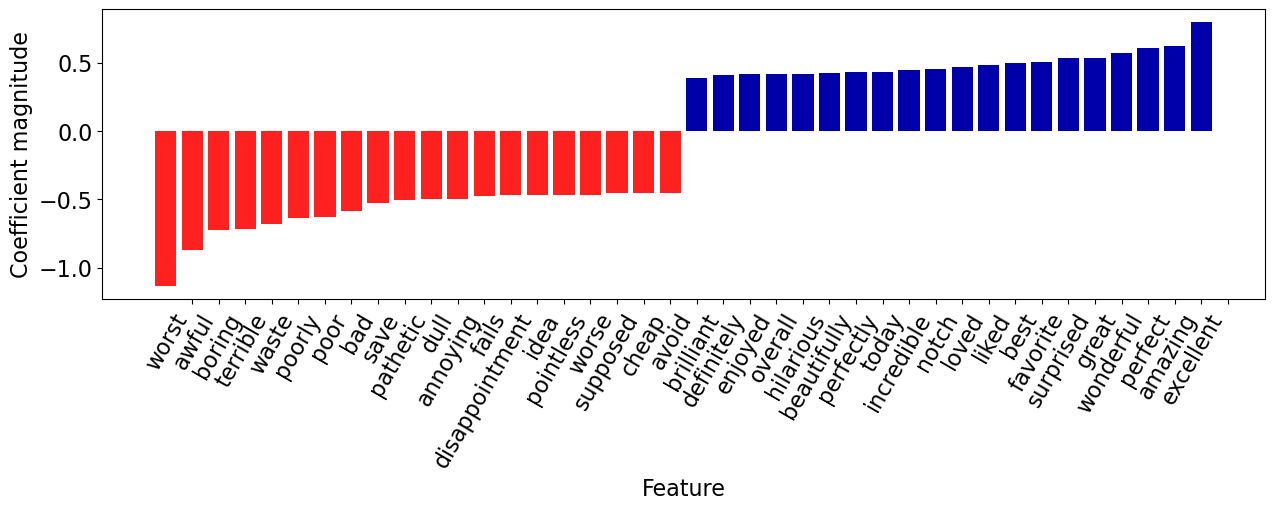

In [22]:
mglearn.tools.visualize_coefficients(coeffs, feature_names, n_top_features=20)

Let's explore prediction of the following new review. 

In [23]:
fake_review = "It got a bit boring at times but the direction was excellent and the acting was flawless. Overall I enjoyed the movie and I highly recommend it!"

In [24]:
feat_vec = pipe_lr.named_steps["countvectorizer"].transform([fake_review])

In [25]:
feat_vec

<1x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 13 stored elements in Compressed Sparse Row format>

Let's get prediction probability scores of the fake review. 

In [26]:
pipe_lr.predict_proba([fake_review])

array([[0.17333954, 0.82666046]])

In [27]:
pipe_lr.classes_

array(['negative', 'positive'], dtype=object)

The model is 82.7% confident that it's a positive review. 

In [28]:
pipe_lr.predict([fake_review])[0]

'positive'

We can find which of the vocabulary words are present in this review:

In [29]:
feat_vec.toarray().ravel().astype(bool)

array([False, False, False, ..., False, False, False])

In [30]:
words_in_ex = feat_vec.toarray().ravel().astype(bool)
words_in_ex

array([False, False, False, ..., False, False, False])

How many of the words are in this review?

In [31]:
np.sum(words_in_ex)

13

In [32]:
ex_df = pd.DataFrame(
    data=coeffs[words_in_ex],
    index=np.array(feature_names)[words_in_ex],
    columns=["Coefficient"],
)

ex_df

,Coefficient
acting,-0.194883
bit,0.327412
boring,-0.725668
direction,-0.138571
enjoyed,0.416470
excellent,0.794894
flawless,0.066854
got,-0.087397
highly,0.328111
movie,-0.033348


Let's visualize how the words with positive and negative coefficients are driving the prediction. 

In [33]:
np.array(feature_names)[words_in_ex]

array(['acting', 'bit', 'boring', 'direction', 'enjoyed', 'excellent',
       'flawless', 'got', 'highly', 'movie', 'overall', 'recommend',
       'times'], dtype=object)

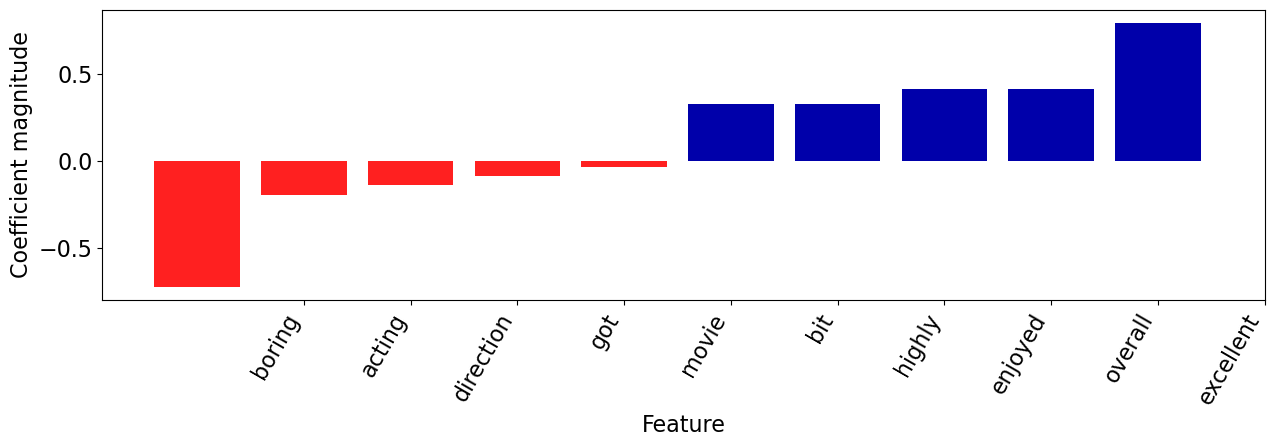

In [34]:
mglearn.tools.visualize_coefficients(
    coeffs[words_in_ex], np.array(feature_names)[words_in_ex], n_top_features=5
)

In [35]:
def plot_coeff_example(feat_vect, coeffs, feature_names):
    words_in_ex = feat_vec.toarray().ravel().astype(bool)

    ex_df = pd.DataFrame(
        data=coeffs[words_in_ex],
        index=np.array(feature_names)[words_in_ex],
        columns=["Coefficient"],
    )
    return ex_df

### Most positive review 

- Remember that you can look at the probabilities (confidence) of the classifier's prediction using the `model.predict_proba` method.
- Can we find the reviews where our classifier is most confident or least confident?

In [36]:
pos_probs = pipe_lr.predict_proba(X_train)[
    :, 1
]  # only get probabilities associated with pos class
pos_probs

array([0.97581663, 0.27576982, 0.93402132, ..., 0.75329946, 0.87516818,
       0.00630932])

Let's get the index of the example where the classifier is most confident (highest `predict_proba` score for positive). 

In [37]:
most_positive = np.argmax(pos_probs)

In [38]:
X_train.iloc[most_positive]

'This is an awesome Amicus horror anthology, with 3 great stories, and fantastic performances!, only the last story disappoints. All the characters are awesome, and the film is quite chilling and suspenseful, plus Peter Cushing and Christopher Lee are simply amazing in this!. It\'s very underrated and my favorite story has to be the 3rd one "Sweets To The Sweet", plus all the characters are very likable. Some of it\'s predictable, and the last story was incredibly disappointing and rather bland!, however the ending was really cool!. This is an awesome Amicus horror anthology, with 3 great stories, and fantastic performances, only the last story disappoints!, i say it\'s must see!.  1st Story ("Method for Murder"). This is an awesome story, with plenty of suspense, and the killer Dominic is really creepy, and it\'s very well acted as well!. This was the perfect way to start off with a story, and for the most part it\'s unpredictable, plus the double twist ending is shocking, and quite c

In [39]:
print("True target: %s\n" % (y_train.iloc[most_positive]))
print("Predicted target: %s\n" % (pipe_lr.predict(X_train.iloc[[most_positive]])[0]))
print("Prediction probability: %0.4f" % (pos_probs[most_positive]))

True target: positive

Predicted target: positive

Prediction probability: 1.0000


Let's examine the features associated with the review. 

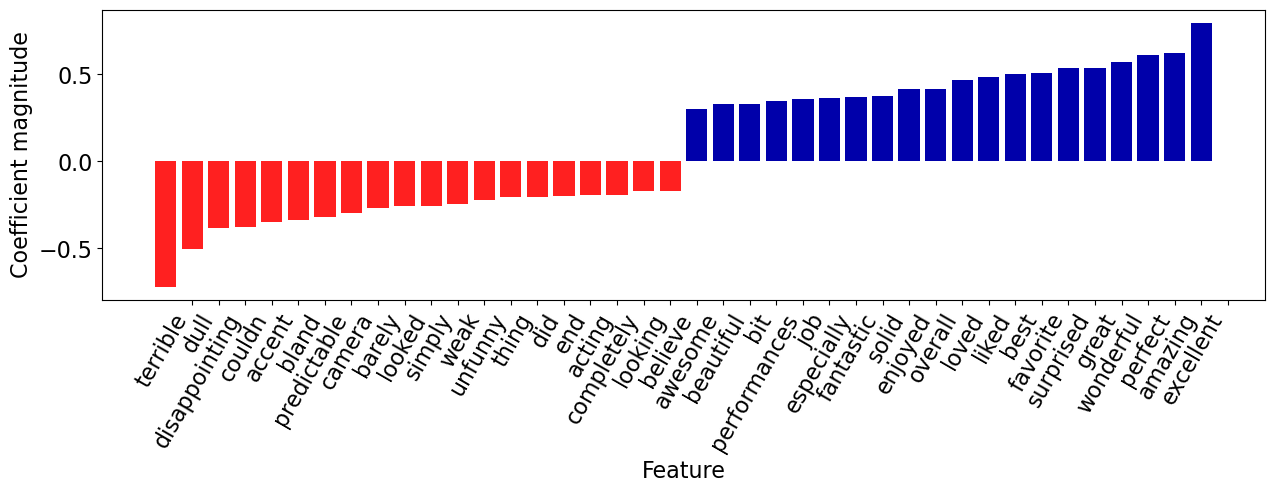

In [40]:
feat_vec = pipe_lr.named_steps["countvectorizer"].transform(
    X_train.iloc[[most_positive]]
)
words_in_ex = feat_vec.toarray().ravel().astype(bool)
mglearn.tools.visualize_coefficients(
    coeffs[words_in_ex], np.array(feature_names)[words_in_ex], n_top_features=20
)

The review has both positive and negative words but the words with **positive** coefficients win in this case! 

### Most negative review 

In [41]:
neg_probs = pipe_lr.predict_proba(X_train)[
    :, 0
]  # only get probabilities associated with pos class
neg_probs

array([0.02418337, 0.72423018, 0.06597868, ..., 0.24670054, 0.12483182,
       0.99369068])

In [42]:
most_negative = np.argmax(neg_probs)

In [43]:
print("Review: %s\n" % (X_train.iloc[[most_negative]]))
print("True target: %s\n" % (y_train.iloc[most_negative]))
print("Predicted target: %s\n" % (pipe_lr.predict(X_train.iloc[[most_negative]])[0]))
print("Prediction probability: %0.4f" % (pos_probs[most_negative]))

Review: 13452    Zombi 3 starts as a group of heavily armed men steal a experimental chemical developed to reanimate the dead, while trying to escape the man is shot at & the metal container holding the chemical i...
Name: review_pp, dtype: object

True target: negative

Predicted target: negative

Prediction probability: 0.0000


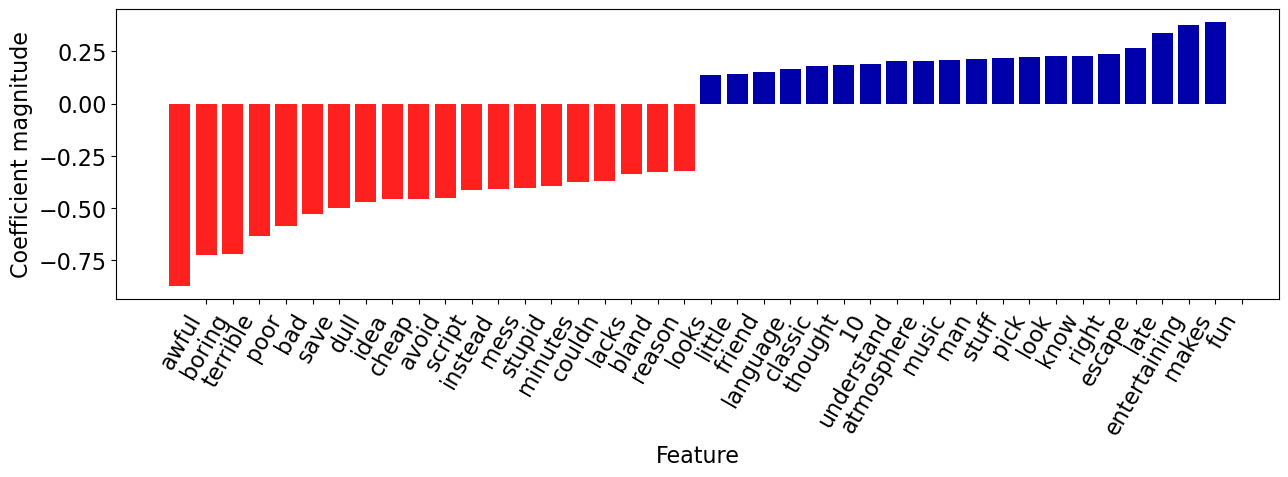

In [44]:
feat_vec = pipe_lr.named_steps["countvectorizer"].transform(
    X_train.iloc[[most_negative]]
)
words_in_ex = feat_vec.toarray().ravel().astype(bool)
mglearn.tools.visualize_coefficients(
    coeffs[words_in_ex], np.array(feature_names)[words_in_ex], n_top_features=20
)

The review has both positive and negative words but the words with negative coefficients win in this case! 

## ❓❓ Questions for you

#### Question for you to ponder on 

- Is it possible to identify most important features using $k$-NNs? What about decision trees?  
